# Домашнее задание №2 
## «Элементарные методы анализа временных рядов»

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель
___

1. Загрузка библиотек
2. Загрузка датасетов с временными рядами (выберем два временных ряда)
    2.1. Международные авиаперевозки пассажиров  
    2.2. Средняя ежемесячная температура по месяцам   
3. Предварительный визуальный анализ выбранных временных рядов и их стабилизированных версий
4. Определение базовых функций для исследования рядов и их предсказания
5. Последовательный анализ и преобразование каждого из рядов  
    5.1. Международные авиаперевозки пассажиров  
    5.4. Средняя ежемесячная температура по месяцам  


## 1. Загрузка библиотек

In [164]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Библиотеки для подбора параметров
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Для кросс-валидации
from sklearn.model_selection import TimeSeriesSplit

## 2. Загрузка датасетов с временными рядами
Выбираем два датасета:
- Международные авиаперевозки пассажиров  
- Среднемесячная температура  

Первый имеет и тренд, и увеличивающуюся дисперсию, и сезонность.  
Второй явно имеет сезонность, а остальные особенности этого ряда не настолько заметны.

In [22]:
airlines_passengers = pd.read_csv("../Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../Series/mean-monthly-air-temperature-deg.csv")

## 3. Предварительный визуальный анализ выбранных временных рядов и их стабилизированных версий

### 3.0 Определим функцию для отрисовки нескольких датасетов на одном графике (или одного)

In [51]:
# Ссылка для себя - для понимания конструкции plt.style.context('bmh'): *Bayesian Methods for Hackers
# There is a very nice short online book called Probabilistic Programming and Bayesian Methods for Hackers; 
# it features figures created with Matplotlib, and uses a nice set of rc parameters 
# to create a consistent and visually-appealing style throughout the book.

def plot_dts(DataSets, Title, W=14, H=5):
    with plt.style.context('bmh'):    
        plt.figure(figsize=(W, H))
        cnt=0
        for dSet in DataSets:
            cnt += 1
            plt.plot(dSet['seria'], dSet['color'], label=dSet.get('label', f'seria {cnt}'))            
        plt.title(Title)
        if cnt > 1:
            plt.legend()

# Определим 4 датасета для последующего анализа.

### 3.1 Авиаперевозки
- airlines_raw - исходный ряд, 
- airlines_stab - стабилизированный

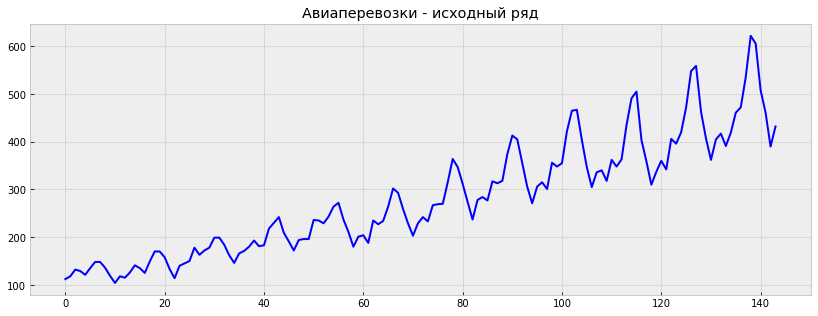

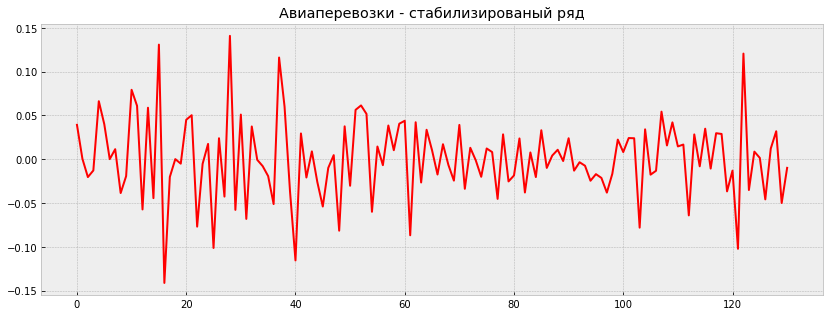

In [52]:
# Исходный:
airlines_raw = airlines_passengers['Count'].copy()

# Стабилизированный
airlines_stab = boxcox(airlines_raw, 0)
airlines_stab = airlines_stab[1:] - airlines_stab[:-1]
airlines_stab = airlines_stab[12:] - airlines_stab[:-12]

plot_dts([{'seria': airlines_raw, 'color': 'blue'}], 'Авиаперевозки - исходный ряд')
plot_dts([{'seria': airlines_stab, 'color': 'red'}], 'Авиаперевозки - стабилизированый ряд')


Предварительно можно сказать, что исходный ряд визуально имеет следующие характеристики:
- ярко выраженный тренд, 
- увеличивающуюся со временем дисперсию
- сезонность

Стабилизированная версия этого ряда имеет матожидание 0 и, судя по тестам, равномерную дисперсию.

### 3.2 Среднемесячная температура
- monthly_temp - исходный ряд, 
- monthly_temp_stab - стабилизированный

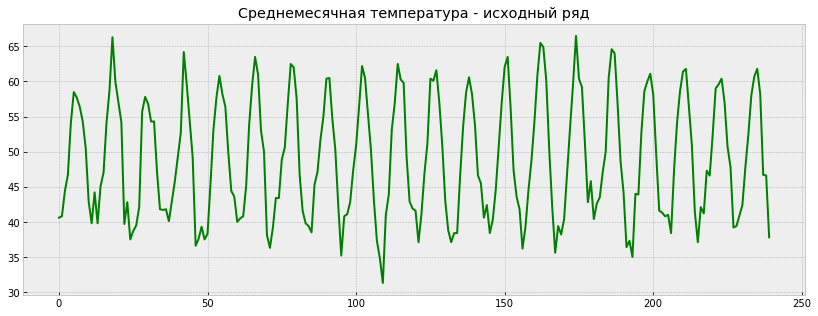

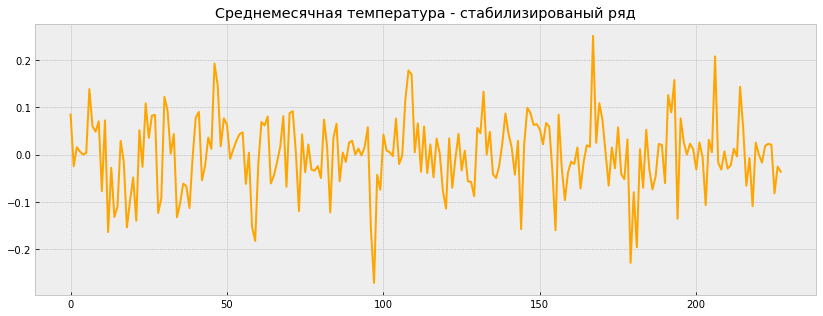

In [266]:
# Исходный:
monthly_temp_raw = mean_monthly_temp['Deg'].copy()

# Стабилизированный
monthly_temp_stab = boxcox(monthly_temp, 0)
monthly_temp_stab = monthly_temp_stab[12:] - monthly_temp_stab[:-12]

plot_dts([{'seria': monthly_temp_raw, 'color': 'green'}], 'Среднемесячная температура - исходный ряд')
plot_dts([{'seria': monthly_temp_stab, 'color': 'orange'}], 'Среднемесячная температура - стабилизированый ряд')


Предварительно можно сказать, что исходный ряд визуально имеет следующие характеристики:
- тренд и переменная дисперсия не наблюдаются, 
- сезонность с периодом в 12 месяцев
- что-то похожее на цикл с бОльшим периодом (в районе 15 лет), быть может, случайный

Стабилизированная версия этого ряда имеет матожидание 0 и, судя по тестам, равномерную дисперсию.

## 4. Определение базовых функций для исследования рядов и их предсказания
Определения функций переупаковываем из лекционного ноутбука, заодно получая компактный конспект

#### 4.1 Скользящее среднее
Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо просто предсказания вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [253]:
# Предсказание следующего значения на основании n предыдущих для всего ряда
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

# Предсказание n_pred значений на основании последних N значений
def predict_ma(series, N, n_pred):
    new_series = series.copy()
    if not isinstance(new_series, pd.Series):
        new_series = pd.Series(new_series)

    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

#### 4.2 Взвешенное скользящее среднее
Модификацией обычной скользящей средней является взвешенная скользящая средняя.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес

In [113]:
# Предсказание следующего значения на основании предыдущих значений с весами weights для всего ряда
def weighted_moving_average(series, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    n = len(weights)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

# Предсказание n_pred значений на основании предыдущих значений с весами weights
def predict_wma(series, weights, n_pred):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    new_series = series.copy()

    n = len(weights)
    for _ in range(n_pred):
        pred_value = pd.Series((new_series[-n:] * weights).sum() / weights.sum())
        new_series = new_series.append(pred_value, ignore_index=True)
    return new_series

#### 4.3 Экспоненциальное сглаживание
Продолжаем развивать идею с историей. Мы хотим учитывать на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное среднее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

In [260]:
# Предсказание n_pred следующих значений. Если n_pred не задано, предсказывается одно значение
# Метапараметр alpha определяет важность последнего значения и/или истории значений
# ВАЖНО: если n_pred не задано, то функция возвращает одну серию - исходную плюс предсказанный параметр.
# В противном случае возвращаются две серии. Серия только предсказаний и серия исходного ряда плюс предсказания.
def exponential_moving_average(series, alpha, n_pred=None):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

#### 4.4 Двойное экспоненциальное сглаживание
До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [132]:
# Предсказание следующего значения на основании предыдущих значений на основе комбинации гиперпараметров alpha и beta
# Предсказание n_pred значений
def double_ema(series, alpha, beta, n_preds=None):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    if not n_preds:
        return pd.Series(result)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

#### 4.5 Метод Хольта-Винтерса
Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [239]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len for i in range(season_len)]) / season_len

In [240]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [241]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return pd.Series(result)

#### 4.6 Подбор параметров
Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [ ]:
def optimize_tema(train, test):
    def mse(X):
        alpha, beta, gamma = X
        result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
        predictions = result[-len(test):]
        error = mean_squared_error(predictions, test)
        return error

    return minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

#### 4.7 Кросс-валидация
Проблема кросс-валидации на временных рядах состоит в том, что случайно перемешивать в фолдах значения всего ряда нельзя. Т.к. он имеет временную структуру, и ее надо сохранять (иначе потеряются все взаимосвязи наблюдений);

Будем делать кросс-валидацию на скользящем окне.

Суть достаточно проста:
1. Берем t измерений
2. Делаем прогноз на n измерений вперед и считаем ошибку
3. Берем t+n измерений
4. Делаем прогноз на n измерений вперед и считаем ошибку
5. Берем t+2*n измерений
6. Делаем прогноз на n измерений вперед и считаем ошибку
...

In [278]:
def cross_validate_tema(train, cycle=12):
    if not isinstance(train, pd.Series):
        train = pd.Series(train)

    def mse_cross_val(X):
        alpha, beta, gamma = X
        split = TimeSeriesSplit(n_splits=3) 
        errors = []

        for train_split, test_split in split.split(train):
            #print(alpha, beta, gamma)
            train_split_ts = train.iloc[train_split]
            test_split_ts = train.iloc[test_split]
            #print(train_split_ts)
            #print(test_split_ts)
            result = triple_exponential_smoothing(train_split_ts, cycle, alpha, beta, gamma, len(test_split))
            predictions = result[-len(test_split_ts):]
            error = mean_squared_error(predictions, test_split_ts)
            errors.append(error)
        print(f'{np.mean(np.array(errors))}------------')
        return np.mean(np.array(errors))
#    return minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
    return minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

## 5. Последовательный анализ и преобразование каждого из рядов

### 5.1 Международные авиаперевозки, исходный ряд
Этот ряд анализируется с помощью всех рассмотренных на лекции методов.
Последующие будут анализироваться без избыточности :)

##### 5.1.1 Скользящее среднее (movie average)

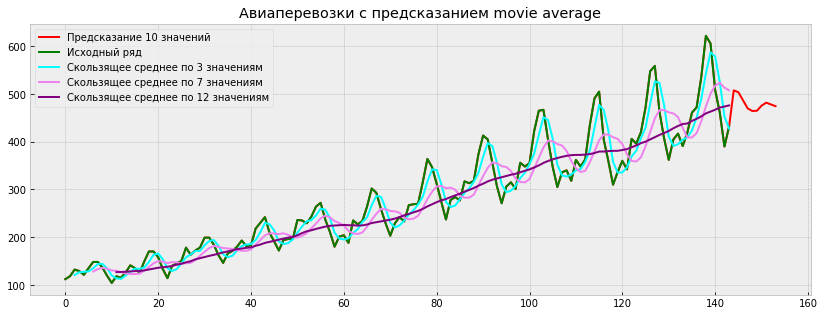

In [254]:
airlines_raw_ma_3 = moving_average(airlines_raw, 3)
airlines_raw_ma_7 = moving_average(airlines_raw, 7)
airlines_raw_ma_12 = moving_average(airlines_raw, 12)
airlines_raw_pred_ma_7_10 = predict_ma(airlines_raw, 7, 10)
DataSets = [
        {'seria': airlines_raw_pred_ma_7_10, 'color': 'red', 'label': 'Предсказание 10 значений'},
        {'seria': airlines_raw, 'color': 'green', 'label': 'Исходный ряд'},
        {'seria': airlines_raw_ma_3, 'color': 'cyan', 'label': 'Скользящее среднее по 3 значениям'},
        {'seria': airlines_raw_ma_7, 'color': 'violet', 'label': 'Скользящее среднее по 7 значениям'},
        {'seria': airlines_raw_ma_12, 'color': 'purple', 'label': 'Скользящее среднее по 12 значениям'}
    ]

plot_dts(DataSets, 'Авиаперевозки с предсказанием movie average')

Для исходного ряда, имеющего множество признаков нестабильности, использование этого самого простого метода явно неэффективно. Предсказание по 7 предыдущим значениям приводит к проявлению эффектов запаздывания, сильного сглаживания кривой, и к явному затуханию при предсказании более чем 1 значения вперед.

##### 5.1.2 Взвешенное скользящее среднее (weighted movie average)

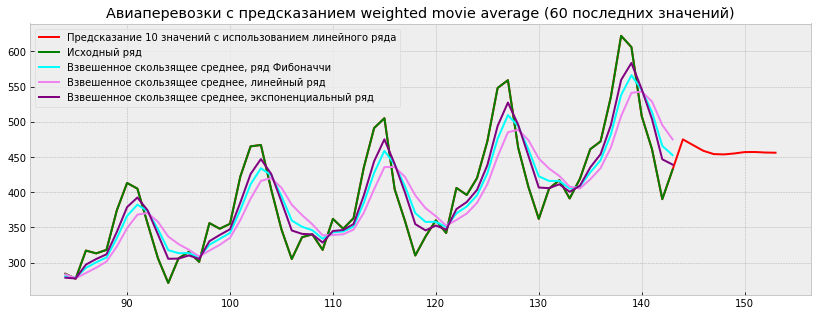

In [122]:
fib_ = [1,1,2,3,5,8,13]
seq_ = [1,2,3,4,5,6,7]
pow_ = [1,2,4,8,16,32,64]
airlines_raw_wma_fib = weighted_moving_average(airlines_raw, fib_)
airlines_raw_wma_seq = weighted_moving_average(airlines_raw, seq_)
airlines_raw_wma_pow = weighted_moving_average(airlines_raw, pow_)
airlines_raw_pred_seq_pow_10 = predict_wma(airlines_raw, seq_, 10)
DataSets = [
        {'seria': airlines_raw_pred_wma_pow_10[-70:], 'color': 'red', 
             'label': 'Предсказание 10 значений с использованием линейного ряда'},
        {'seria': airlines_raw[-60:], 'color': 'green', 
             'label': 'Исходный ряд'},
        {'seria': airlines_raw_wma_fib[-60:], 'color': 'cyan', 
             'label': 'Взвешенное скользящее среднее, ряд Фибоначчи'},
        {'seria': airlines_raw_wma_seq[-60:], 'color': 'violet', 
             'label': 'Взвешенное скользящее среднее, линейный ряд'},
        {'seria': airlines_raw_wma_pow[-60:], 'color': 'purple', 
             'label': 'Взвешенное скользящее среднее, экспоненциальный ряд'}
    ]

plot_dts(DataSets, 'Авиаперевозки с предсказанием weighted movie average (60 последних значений)')

В данном случае видим, что взвешенное скользящее среднее с использованием экспоненциального ряда дает неплохое приближение, но опять-таки - с запаздыванием. Предсказание 10 значений в данном случае также, как и в случае с использованием метода скользящего среднего, приводит к драматическому затуханию ряда.
Продолжим эксперименты.

##### 5.1.3 Экспоненциальное сглаживание (exponential movie average)

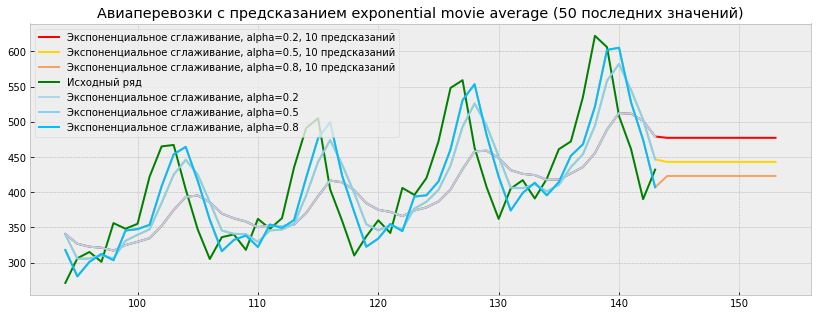

In [130]:
airlines_raw_ema_02 = exponential_moving_average(airlines_raw, 0.2)
airlines_raw_ema_05 = exponential_moving_average(airlines_raw, 0.5)
airlines_raw_ema_08 = exponential_moving_average(airlines_raw, 0.8)
airlines_raw_ema_02_10 = exponential_moving_average(airlines_raw, 0.2, 10)[1]
airlines_raw_ema_05_10 = exponential_moving_average(airlines_raw, 0.5, 10)[1]
airlines_raw_ema_08_10 = exponential_moving_average(airlines_raw, 0.8, 10)[1]

DataSets = [
        {'seria': airlines_raw_ema_02_10[-60:], 'color': 'red', 
             'label': 'Экспоненциальное сглаживание, alpha=0.2, 10 предсказаний'},
        {'seria': airlines_raw_ema_05_10[-60:], 'color': 'gold', 
             'label': 'Экспоненциальное сглаживание, alpha=0.5, 10 предсказаний'},
        {'seria': airlines_raw_ema_08_10[-60:], 'color': 'sandybrown', 
             'label': 'Экспоненциальное сглаживание, alpha=0.8, 10 предсказаний'},
        {'seria': airlines_raw[-50:], 'color': 'green', 
             'label': 'Исходный ряд'},
        {'seria': airlines_raw_ema_02[-50:], 'color': 'lightblue', 
             'label': 'Экспоненциальное сглаживание, alpha=0.2'},
        {'seria': airlines_raw_ema_05[-50:], 'color': 'lightskyblue', 
             'label': 'Экспоненциальное сглаживание, alpha=0.5'},
        {'seria': airlines_raw_ema_08[-50:], 'color': 'deepskyblue', 
             'label': 'Экспоненциальное сглаживание, alpha=0.8'}
    ]

plot_dts(DataSets, 'Авиаперевозки с предсказанием exponential movie average (50 последних значений)')

Работа этого алгоритма напоминает предыдущий алогритм. При более высоких значениях alpha кривая предсказания приближается к исходной с запаздыванием, равным более чем одному шагу, но практически при любом значении альфы предсказание на несколько шагов вперед быстро вырождается в горизонталь.

##### 5.1.4 Двойное экспоненциальное сглаживание (exponential movie average)

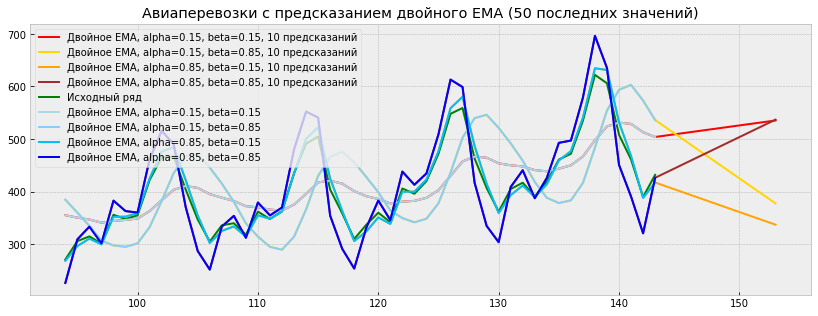

In [134]:
airlines_raw_dema_015_015 = double_ema(airlines_raw, 0.15, 0.15)
airlines_raw_dema_015_085 = double_ema(airlines_raw, 0.15, 0.85)
airlines_raw_dema_085_015 = double_ema(airlines_raw, 0.85, 0.15)
airlines_raw_dema_085_085 = double_ema(airlines_raw, 0.85, 0.85)
airlines_raw_dema_015_015_10 = double_ema(airlines_raw, 0.15, 0.15, 10)[1]
airlines_raw_dema_015_085_10 = double_ema(airlines_raw, 0.15, 0.85, 10)[1]
airlines_raw_dema_085_015_10 = double_ema(airlines_raw, 0.85, 0.15, 10)[1]
airlines_raw_dema_085_085_10 = double_ema(airlines_raw, 0.85, 0.85, 10)[1]

DataSets = [
        {'seria': airlines_raw_dema_015_015_10[-60:], 'color': 'red', 
             'label': 'Двойное EMA, alpha=0.15, beta=0.15, 10 предсказаний'},
        {'seria': airlines_raw_dema_015_085_10[-60:], 'color': 'gold', 
             'label': 'Двойное EMA, alpha=0.15, beta=0.85, 10 предсказаний'},
        {'seria': airlines_raw_dema_085_015_10[-60:], 'color': 'orange', 
             'label': 'Двойное EMA, alpha=0.85, beta=0.15, 10 предсказаний'},
        {'seria': airlines_raw_dema_085_085_10[-60:], 'color': 'brown', 
             'label': 'Двойное EMA, alpha=0.85, beta=0.85, 10 предсказаний'},
        {'seria': airlines_raw[-50:], 'color': 'green', 
             'label': 'Исходный ряд'},
        {'seria': airlines_raw_dema_015_015[-50:], 'color': 'lightblue', 
             'label': 'Двойное EMA, alpha=0.15, beta=0.15'},
        {'seria': airlines_raw_dema_015_085[-50:], 'color': 'lightskyblue', 
             'label': 'Двойное EMA, alpha=0.15, beta=0.85'},
        {'seria': airlines_raw_dema_085_015[-50:], 'color': 'deepskyblue', 
             'label': 'Двойное EMA, alpha=0.85, beta=0.15'},
        {'seria': airlines_raw_dema_085_085[-50:], 'color': 'blue', 
             'label': 'Двойное EMA, alpha=0.85, beta=0.85'}
    ]

plot_dts(DataSets, 'Авиаперевозки с предсказанием двойного EMA (50 последних значений)')

В отличие от предыдущего алгоритма здесь мы не видим эффект запаздывания для более высоких значений альфы. Лучшее предсказание получается для рассмотренного варианта с alpha=0.85, beta=0.15. При бОльших значениях beta увеличивается амплитуда колебаний.
Что касается предсказания нескольких значений, практически при любом значении альфы предсказание на несколько шагов вперед быстро вырождается в прямую, которая имеет угол наклона, соответствующий последнему предсказанному тренду.

Для этого временного ряда такое предсказание - плохой результат, но для описания уже случившегося ряда модель может быть точной.

#### 5.1.5 Метод Хольта-Винтерса

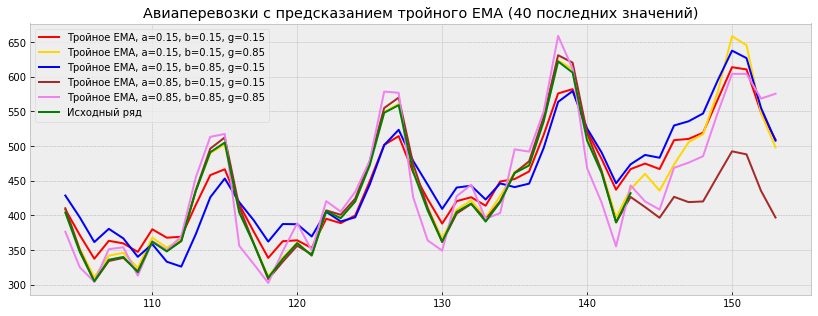

In [163]:
# Для оптимизации кода напишем небольшую функцию
def tema_airlines_raw(alpha, beta, gamma):
    return triple_exponential_smoothing(airlines_raw, 12, alpha, beta, gamma, 10)

# Рассмотрим несколько комбинаций гиперпараметров alpha, beta и gamma
airlines_raw_tema_015_015_015 = tema_airlines_raw(0.15, 0.15, 0.15)
airlines_raw_tema_015_015_085 = tema_airlines_raw(0.15, 0.15, 0.85)
airlines_raw_tema_085_085_015 = tema_airlines_raw(0.15, 0.85, 0.15)
airlines_raw_tema_085_015_015 = tema_airlines_raw(0.85, 0.15, 0.15)
airlines_raw_tema_085_085_085 = tema_airlines_raw(0.85, 0.85, 0.85)


DataSets = [
        {'seria': airlines_raw_tema_015_015_015[-50:], 'color': 'red', 
             'label': 'Тройное EMA, a=0.15, b=0.15, g=0.15'},
        {'seria': airlines_raw_tema_015_015_085[-50:], 'color': 'gold', 
             'label': 'Тройное EMA, a=0.15, b=0.15, g=0.85'},
        {'seria': airlines_raw_tema_085_085_015[-50:], 'color': 'blue', 
             'label': 'Тройное EMA, a=0.15, b=0.85, g=0.15'},
        {'seria': airlines_raw_tema_085_015_015[-50:], 'color': 'brown', 
             'label': 'Тройное EMA, a=0.85, b=0.15, g=0.15'},
        {'seria': airlines_raw_tema_085_085_085[-50:], 'color': 'violet', 
             'label': 'Тройное EMA, a=0.85, b=0.85, g=0.85'},
        {'seria': airlines_raw[-40:], 'color': 'green', 
             'label': 'Исходный ряд'}
    ]

plot_dts(DataSets, 'Авиаперевозки с предсказанием тройного EMA (40 последних значений)')

Визуальный анализ получившихся графиков позволяет явно выделить вариант Тройное EMA, a=0.15, b=0.15, g=0.85, который не только максимально близок к реальной кривой, но еще и довольно похоже предсказывает ближайшие 10 точек.
Однако для того, чтобы выбрать лучший набор параметров при использовании метода Хольта-Винтерса, есть смысл использовать для этого 

#### 5.1.6 Подбор параметров для метода Хольта-Винтерса

In [172]:
train, test, val = airlines_raw[:80], airlines_raw[80:92], airlines_raw[92:]
opt_params = optimize_tema(train, test)
alpha_opt, beta_opt, gamma_opt = opt_params.x
print(f'Оптимизированные параметры: alpha={alpha_opt}, beta={beta_opt}, gamma={gamma_opt}')


Оптимизированные параметры: alpha=1.0, beta=0.025726552195081413, gamma=1.0


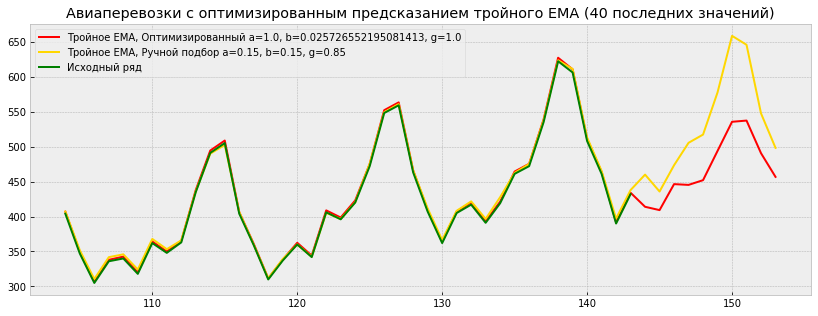

In [175]:
# Сравним оптимизированный вариант и вариант, подобранный вручную на полном датасете

airlines_raw_tema_optimized = tema_airlines_raw(alpha_opt, beta_opt, gamma_opt)
airlines_raw_tema_015_015_085 = tema_airlines_raw(0.15, 0.15, 0.85)
DataSets = [
        {'seria': airlines_raw_tema_optimized[-50:], 'color': 'red', 
             'label': f'Тройное EMA, Оптимизированный a={alpha_opt}, b={beta_opt}, g={gamma_opt}'},
        {'seria': airlines_raw_tema_015_015_085[-50:], 'color': 'gold', 
             'label': 'Тройное EMA, Ручной подбор a=0.15, b=0.15, g=0.85'},
        {'seria': airlines_raw[-40:], 'color': 'green', 
             'label': 'Исходный ряд'}
    ]

plot_dts(DataSets, 'Авиаперевозки с оптимизированным предсказанием тройного EMA (40 последних значений)')

Результат оптимизации неплох, он хорошо "угадал" обучающий набор данных, однако даже случайно вручную найденные параметры дали не менее интересный результат.

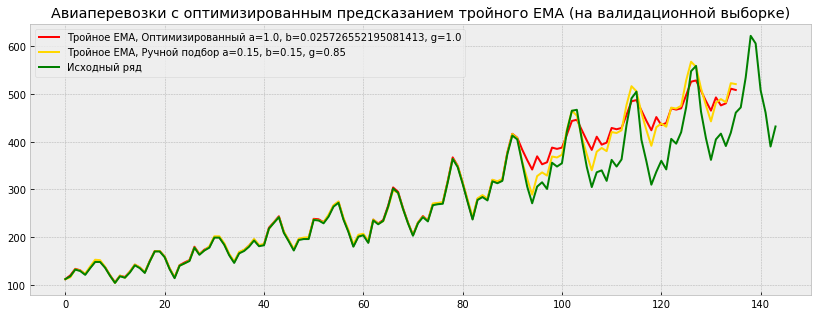

In [258]:
# Теперь посмотрим то же самое для валидационной выборки
airlines_optimized_tema_pred = triple_exponential_smoothing(airlines_raw[:92], 12, alpha_opt, beta_opt, gamma_opt, len(val))
airlines_selection_tema_pred = triple_exponential_smoothing(airlines_raw[:92], 12, 0.15, 0.15, 0.85, len(val))

DataSets = [
        {'seria': airlines_optimized_tema_pred, 'color': 'red', 
             'label': f'Тройное EMA, Оптимизированный a={alpha_opt}, b={beta_opt}, g={gamma_opt}'},
        {'seria': airlines_selection_tema_pred, 'color': 'gold', 
             'label': f'Тройное EMA, Ручной подбор a=0.15, b=0.15, g=0.85'},
        {'seria': airlines_raw, 'color': 'green', 
             'label': 'Исходный ряд'}
    ]

plot_dts(DataSets, 'Авиаперевозки с оптимизированным предсказанием тройного EMA (на валидационной выборке)')

Кажется, результат не блестящий, но в целом характер изменения величины, общий профиль кривой строится более-менее точно.
За четыре предсказанных сезона модель с параметрами, подобранными вручную, оказалась более точной, чем модель с оптимизированными параметрами.
Может быть это связано с какой-то ошибкой, допущенной в коде.
Тем не менее получается, что метод описания ряда с помощью метода Хольта-Винтерса в данном случае дает наилучший результат.

Осталось только посчитать количественные оценки ошибки предсказания с помощью кросс-валидации.

In [247]:
train_cross, val_cross = airlines_raw[:100], airlines_raw[100:]
cross_opt = cross_validate_tema(train_cross)
alpha_cross, beta_cross, gamma_cross = cross_opt.x
print(f'Оптимизированные параметры: alpha={alpha_cross}, beta={beta_cross}, gamma={gamma_cross}')

5923.700673868264------------
5865.905633191115------------
5923.700673868237------------
5918.801560763659------------
5881.599076192787------------
5854.511559742317------------
5821.091095678185------------
5794.430942642194------------
5734.286266187908------------
5734.971337810817------------
5665.88756179692------------
5573.7018425339165------------
5545.527833083393------------
5419.547276351686------------
5418.703331343507------------
5275.70953714782------------
5154.912670641345------------
4931.262376307057------------
4876.561554455627------------
4612.47018770373------------
4543.1721120282755------------
4270.422779411134------------
4167.487666407024------------
3958.784781504095------------
3852.424056255821------------
3734.1898785198628------------
3860.720208683391------------
4078.197658202349------------
3870.695472481981------------
4036.3887454342516------------
3829.9439788954937------------
3811.3274310822308------------
3856.8394772874926------------
3800.9

304.2897571911779------------
304.28990103549506------------
304.2897645682926------------
304.28996648162774------------
304.28974288612------------
304.2898483311562------------
304.28974563827927------------
304.2897437660216------------
304.28981091342416------------
304.2897315877047------------
304.28974351669723------------
304.28975127431016------------
304.28973149225885------------
304.28974389178734------------
304.2897314683273------------
304.2897597540052------------
304.2897299275189------------
304.28974938715------------
304.28972760606445------------
Оптимизированные параметры: alpha=0.17856325776812645, beta=0.611131528265124, gamma=-0.0984332851157145


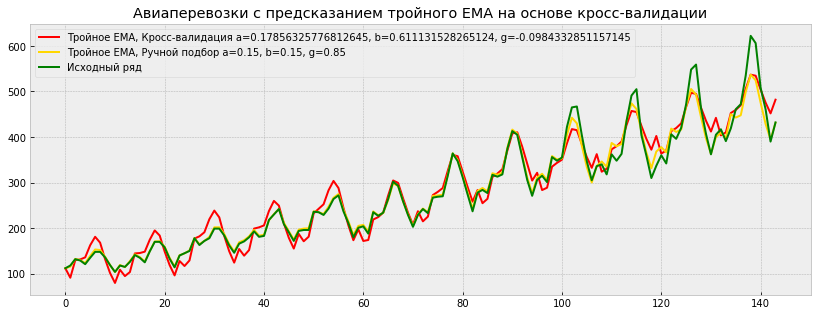

In [250]:
# Теперь сравним подобранные параметры с ручным подбором :)
airlines_cross_tema_pred = triple_exponential_smoothing(airlines_raw[:100], 12, alpha_cross, beta_cross, gamma_cross, len(val_cross))
airlines_selection2_tema_pred = triple_exponential_smoothing(airlines_raw[:100], 12, 0.15, 0.15, 0.85, len(val_cross))

DataSets = [
        {'seria': airlines_cross_tema_pred, 'color': 'red', 
             'label': f'Тройное EMA, Кросс-валидация a={alpha_cross}, b={beta_cross}, g={gamma_cross}'},
        {'seria': airlines_selection2_tema_pred, 'color': 'gold', 
             'label': f'Тройное EMA, Ручной подбор a=0.15, b=0.15, g=0.85'},
        {'seria': airlines_raw, 'color': 'green', 
             'label': 'Исходный ряд'}
    ]

plot_dts(DataSets, 'Авиаперевозки с предсказанием тройного EMA на основе кросс-валидации')

Хорошо видно, что в результате кросс-валидации слегка улучшилась ситуация с предсказаниями на валидационном хвосте ряда, но зато ухудшилась ситуация с перекрытием начального отрезка ряда. И опять случайно подобранные ручные значения кажутся более удачными и в начальной части кривой, и на четырех финальных сезонах ряда.
С чем связан такой результат, понятия не имею. Видимо, не всяким результатам оптимизации надо доверять и ручной перебор вариантов как один из методов поиска решений не стоит сбрасывать со счета.

### 5.2 Международные авиаперевозки, стабилизированный ряд

Поскольку ряд, который мы будем рассматривать здесь, уже стабилизированный, скорее всего бессмысленно использовать предсказание его значений, тем более на несколько шагов вперед.Однако можно посмотреть, используя реализованные ранее функции, не проявится ли каких-либо интересных эффектов.

##### 5.2.1 Метод скользящего среднего

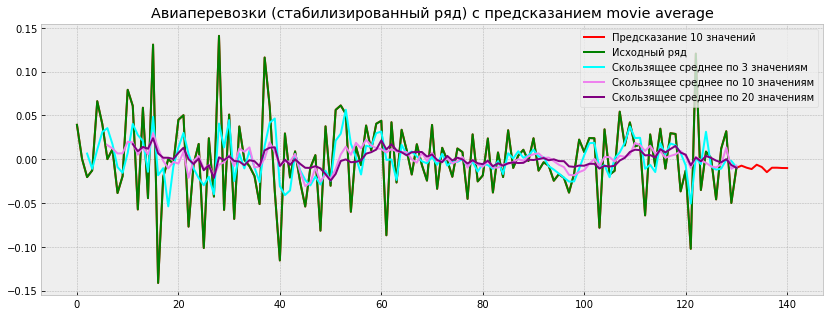

In [257]:
airlines_stab_ma_3 = moving_average(airlines_stab, 3)
airlines_stab_ma_10 = moving_average(airlines_stab, 7)
airlines_stab_ma_20 = moving_average(airlines_stab, 12)
airlines_stab_pred_ma_7_10 = predict_ma(airlines_stab, 7, 10)
DataSets = [
        {'seria': airlines_stab_pred_ma_7_10, 'color': 'red', 'label': 'Предсказание 10 значений'},
        {'seria': airlines_stab, 'color': 'green', 'label': 'Исходный ряд'},
        {'seria': airlines_stab_ma_3, 'color': 'cyan', 'label': 'Скользящее среднее по 3 значениям'},
        {'seria': airlines_stab_ma_10, 'color': 'violet', 'label': 'Скользящее среднее по 10 значениям'},
        {'seria': airlines_stab_ma_20, 'color': 'purple', 'label': 'Скользящее среднее по 20 значениям'}
    ]

plot_dts(DataSets, 'Авиаперевозки (стабилизированный ряд) с предсказанием movie average')

При использовании скользящего среднего с вычислением по 20 предыдущим шагам получаем максимально сглаженную кривую. При этом видно, что пики кривой, как отрицательные, так и положительные, с запаздыванием, но влияют на соответствующие всплески и затухания полученной в результате применения алгоритма кривой.  
Видно, что получившаяся кривая колеблется вокруг нуля, признаков тренда или сезонных колебаний на ней не видно.
Предсказанный участок кривой (10 значений) оказался ниже нуля, но смотря на пики основной кривой понятно, почему предсказание сместилось вниз.

##### 5.2.2 Экспоненциальное сглаживание

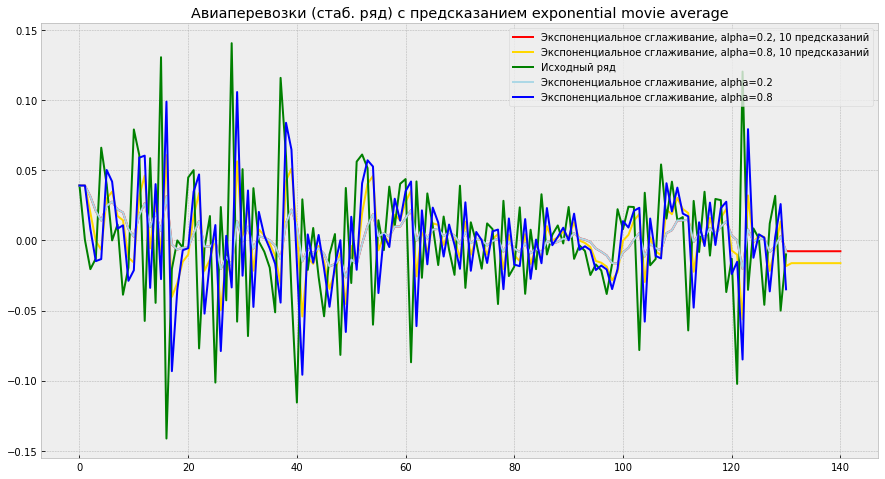

In [265]:
airlines_stab_ema_02 = exponential_moving_average(airlines_stab, 0.2)
airlines_stab_ema_08 = exponential_moving_average(airlines_stab, 0.8)
airlines_stab_ema_02_10 = exponential_moving_average(airlines_stab, 0.2, 10)[1]
airlines_stab_ema_08_10 = exponential_moving_average(airlines_stab, 0.8, 10)[1]

DataSets = [
        {'seria': airlines_stab_ema_02_10, 'color': 'red', 
             'label': 'Экспоненциальное сглаживание, alpha=0.2, 10 предсказаний'},
        {'seria': airlines_stab_ema_05_10, 'color': 'gold', 
             'label': 'Экспоненциальное сглаживание, alpha=0.8, 10 предсказаний'},
        {'seria': airlines_stab, 'color': 'green', 
             'label': 'Исходный ряд'},
        {'seria': airlines_stab_ema_02, 'color': 'lightblue', 
             'label': 'Экспоненциальное сглаживание, alpha=0.2'},
        {'seria': airlines_stab_ema_08, 'color': 'blue', 
             'label': 'Экспоненциальное сглаживание, alpha=0.8'}
    ]

plot_dts(DataSets, 'Авиаперевозки (стаб. ряд) с предсказанием exponential movie average', 15, 8)

В этом случае получившаяся картинка вполне понятна. Наблюдаем близкую к исходной кривую в случае, если alpha высокая, т.е. значимость последних значений при предсказании выше значимости истории и более сглаженную кривую с меньшей дисперсией при небольших значениях коэффициента alpha.

Смотреть эффекты от использования последних двух методов тем более бессмысленно. Тренда у нас нет, поэтому двойное экспоненциальное сглаживание ничего нам не даст, коэффициент beta должен быть нулевым.
Тройное экспоненциальное сглаживание ввиду отстутсвия сезонности тем более сложно применить, поскольку одним из параметров для метода является указание периода сезона, который неизвестен.

Вывод: для анализа стабилизированного ряда можно проверить, нет ли ошибок в оценке ряда как стабилизированного, если использовать самый простой метод скользящего среднего с вычислением значения по 10 - 155 последним шагам и визуально оценив получившийся результат.

### 5.3 Среднемесячная температура, исходный ряд

#### 5.3.1 Метод скользящего среднего

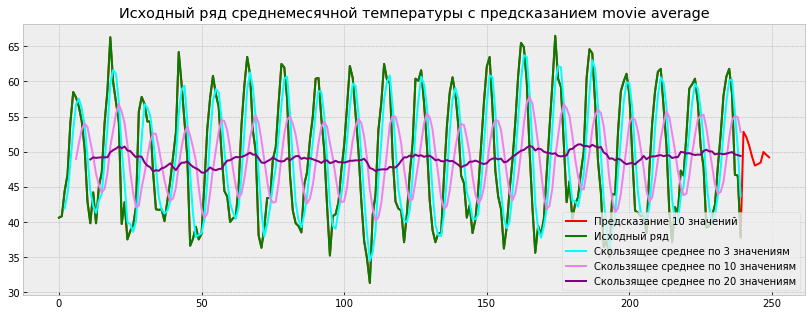

In [267]:
monthly_temp_raw_ma_3 = moving_average(monthly_temp_raw, 3)
monthly_temp_raw_ma_10 = moving_average(monthly_temp_raw, 7)
monthly_temp_raw_ma_20 = moving_average(monthly_temp_raw, 12)
monthly_temp_raw_pred_ma_7_10 = predict_ma(monthly_temp_raw, 7, 10)
DataSets = [
        {'seria': monthly_temp_raw_pred_ma_7_10, 'color': 'red', 'label': 'Предсказание 10 значений'},
        {'seria': monthly_temp_raw, 'color': 'green', 'label': 'Исходный ряд'},
        {'seria': monthly_temp_raw_ma_3, 'color': 'cyan', 'label': 'Скользящее среднее по 3 значениям'},
        {'seria': monthly_temp_raw_ma_10, 'color': 'violet', 'label': 'Скользящее среднее по 10 значениям'},
        {'seria': monthly_temp_raw_ma_20, 'color': 'purple', 'label': 'Скользящее среднее по 20 значениям'}
    ]

plot_dts(DataSets, 'Исходный ряд среднемесячной температуры с предсказанием movie average')

Предварительный анализ ряда с использованием метода скользящего среднего позволяет сделать вывод о том, что у ряда не наблюдается ни тренда, ни цикличности, зато сезонность ряда с периодом 12 месяцев ярко выражена.
В этой связи попробуем сразу использовать кросс-валидацию и метод тройного экспоненциального сглаживания (метод Хольфа-Винтерса)


#### 5.3.2 Подбор параметров для метода Хольта-Винтерса

In [271]:
train_temp_cross, val_temp_cross = monthly_temp_raw[:150], monthly_temp_raw[150:]
cross_temp_opt = cross_validate_tema(train_temp_cross)
alpha_temp_cross, beta_temp_cross, gamma_temp_cross = cross_temp_opt.x
print(f'Оптимизированные параметры: alpha={alpha_temp_cross}, beta={beta_temp_cross}, gamma={gamma_temp_cross}')

71.89965103992613------------
71.96328925032373------------
71.89965103992613------------
71.90561760647914------------
71.8145997864623------------
71.70086410601662------------
71.76187736576857------------
71.67982171651845------------
71.54283948970343------------
71.29202603537406------------
70.74658966529246------------
70.88494002519803------------
70.16575052036727------------
68.84079111909855------------
67.94775785903424------------
64.34029285213308------------
64.38771234469618------------
56.959433283305835------------
42.6322517876279------------
39.9534622036339------------
17.788993405627085------------
16.857427338870195------------
60.784275341475755------------
137.90650325043353------------
48.43980339606247------------
17.911921051165354------------
111.95342252330637------------
26.638742528318925------------
27.106923488286295------------
19.41652812996088------------
15.893897413059294------------
27.1069234882863------------
22.488658020843435------------
14.

7.490010475138177------------
7.464071203749508------------
7.491207418293162------------
7.46278799221836------------
7.4174026315049995------------
7.389584520629061------------
7.415792257946381------------
7.461104535251672------------
7.416063972824183------------
7.351550370192464------------
7.314206138231189------------
7.367581940160227------------
7.376262081975779------------
7.289625575913725------------
7.230537013006505------------
7.277177233148124------------
7.25994701946415------------
7.199132775552697------------
7.3453221048799655------------
7.187160752340211------------
7.368493639551162------------
7.126131794399313------------
7.134576620636845------------
7.4177255003225016------------
7.169810786312603------------
7.12862230117484------------
7.29787145064271------------
7.133416957829177------------
7.076227797915103------------
7.041875429325235------------
7.093158822277066------------
7.027617002801165------------
7.006715458877577------------
6.997773176

6.261025732622929------------
6.261084007154849------------
6.261087180808367------------
6.2609657484628345------------
6.260917609453339------------
6.26106291340507------------
6.260977082959254------------
6.261348418025251------------
6.260976713117182------------
6.260856824304429------------
6.260799922411196------------
6.260946198323622------------
6.260807025169709------------
6.261052774211156------------
6.260861272206324------------
6.260729565974571------------
6.260839402535417------------
6.260994924406593------------
6.2607992933942------------
6.260771675273992------------
6.260725842834315------------
6.260724258732687------------
6.260663307560101------------
6.2607570468105------------
6.260751790238596------------
6.260694707547157------------
6.260645824884456------------
6.260636102415351------------
6.260704328607605------------
6.2606442223520835------------
6.2605682830675855------------
6.2605256138890555------------
6.260561436446372------------
6.260531586

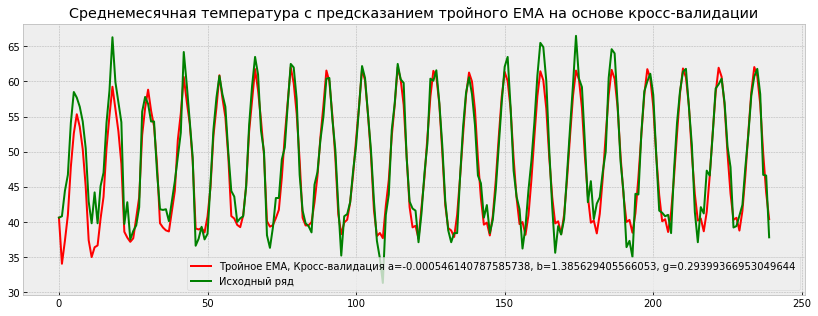

In [272]:
# Теперь сравним предсказанный ряд с исходным
monthly_temp_cross_tema_pred = triple_exponential_smoothing(monthly_temp_raw[:150], 12, 
                                                            alpha_temp_cross, beta_temp_cross, gamma_temp_cross, 
                                                            len(val_temp_cross))

DataSets = [
        {'seria': monthly_temp_cross_tema_pred, 'color': 'red', 
             'label': f'Тройное EMA, Кросс-валидация a={alpha_temp_cross}, b={beta_temp_cross}, g={gamma_temp_cross}'},
        {'seria': monthly_temp_raw, 'color': 'green', 
             'label': 'Исходный ряд'}
    ]

plot_dts(DataSets, 'Среднемесячная температура с предсказанием тройного EMA на основе кросс-валидации')

По графику видно, что предсказанные точки (после 150-й)лежатна близкой к синусоиде кривой. Тренд у синусоиды отсутствует, естественно отсутствуют и случайные отклонения амплитуд для реальной кривой. В остальном можно считать полученный результат довольно точным попаданием.

### 5.4 Среднемесячная температура, стабилизированный ряд

Фактически в данном случае ряд по характеру не должен отличаться от стабилизированного ряда для авиаперевозок, рассмотренного выше. В этой связи просто повторим те же шаги и посмотрим, не проявятся ли в данном случае какие-то новые эффекты, которых не было у первого рассмотренного стабилизированного ряда.

#### 5.4.1 Метод скользящего среднего

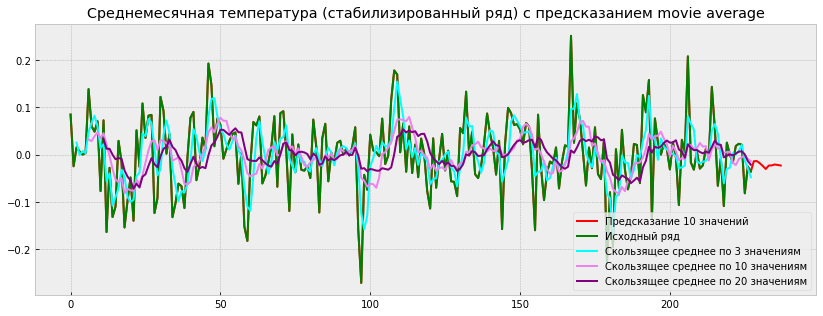

In [274]:
monthly_temp_stab_ma_3 = moving_average(monthly_temp_stab, 3)
monthly_temp_stab_ma_10 = moving_average(monthly_temp_stab, 7)
monthly_temp_stab_ma_20 = moving_average(monthly_temp_stab, 12)
monthly_temp_stab_pred_ma_7_10 = predict_ma(monthly_temp_stab, 7, 10)
DataSets = [
        {'seria': monthly_temp_stab_pred_ma_7_10, 'color': 'red', 'label': 'Предсказание 10 значений'},
        {'seria': monthly_temp_stab, 'color': 'green', 'label': 'Исходный ряд'},
        {'seria': monthly_temp_stab_ma_3, 'color': 'cyan', 'label': 'Скользящее среднее по 3 значениям'},
        {'seria': monthly_temp_stab_ma_10, 'color': 'violet', 'label': 'Скользящее среднее по 10 значениям'},
        {'seria': monthly_temp_stab_ma_20, 'color': 'purple', 'label': 'Скользящее среднее по 20 значениям'}
    ]

plot_dts(DataSets, 'Среднемесячная температура (стабилизированный ряд) с предсказанием movie average')

С одной стороны мы видим, что в этом стабилизированном ряду явно нет тренда. С другой стороны пожно увидеть здесь признаки цикла (примерно пятилетнего), видимо, связанного так или иначе с циклами солнечной активности. Однако у этого цикла нет явного периода. Посмотрим, удастся ли поймать этот цикл при использовании метода Хольта-Винтерса.

#### 5.4.2 Подбор параметров для метода Хольта-Винтерса
К сожалению количества данных в этом ряду мало для того, чтобы проверить 60-месячный цикл. 
В этой связи посчитаем коэффициенты для этого метода для 12-летнего цикла...

In [283]:
train_temp_stab_cross, val_temp_stab_cross = monthly_temp_stab[:150], monthly_temp_stab[150:]
cross_temp_stab_opt = cross_validate_tema(train_temp_stab_cross)
alpha_temp_stab_cross, beta_temp_stab_cross, gamma_temp_stab_cross = cross_temp_stab_opt.x
print(f'Оптимизированные параметры: alpha={alpha_temp_stab_cross}, beta={beta_temp_stab_cross}, gamma={gamma_temp_stab_cross}')

0.6118637354630315------------
0.6018461245105109------------
0.6118637354630315------------
0.6110206244876044------------
0.6046874440132214------------
0.5999260640001552------------
0.5941523247539617------------
0.5898383706957907------------
0.5799169925592974------------
0.5792632678753282------------
0.5671440087000402------------
0.5604495885177795------------
0.5423136404983205------------
0.534506092438091------------
0.5095155846464419------------
0.5024184800661851------------
0.4713976506099508------------
0.4604935962323549------------
0.42671941752503145------------
0.4116227952520033------------
0.3751440742399073------------
0.366756918734325------------
0.3412710259813551------------
0.34389319172733296------------
0.3305204951334855------------
0.3498296355379043------------
0.35366129100698496------------
0.33893733773820783------------
0.3256640003155485------------
0.32100131801922266------------
0.35339628711921617------------
0.33046578169535795------------
0.3

0.008203669120410722------------
0.00820370388708192------------
0.008203673536002792------------
0.008203677009256732------------
0.00820368935233409------------
0.0082036703839091------------
0.008203678104363362------------
0.008203670265773039------------
0.008203674877657673------------
0.008203669302169916------------
0.008203672649476475------------
0.008203668444627714------------
0.008203668500165412------------
0.008203669616364486------------
0.008203667934044407------------
0.008203672322946115------------
0.008203667685981398------------
0.008203669693672361------------
0.008203667723441138------------
0.008203668755605778------------
0.008203667768686392------------
0.008203667622342469------------
0.008203668190160792------------
0.008203668439766146------------
0.008203667530839896------------
0.00820366791129311------------
0.008203667559599446------------
0.008203667653948464------------
0.008203667545672692------------
Оптимизированные параметры: alpha=0.028242850239

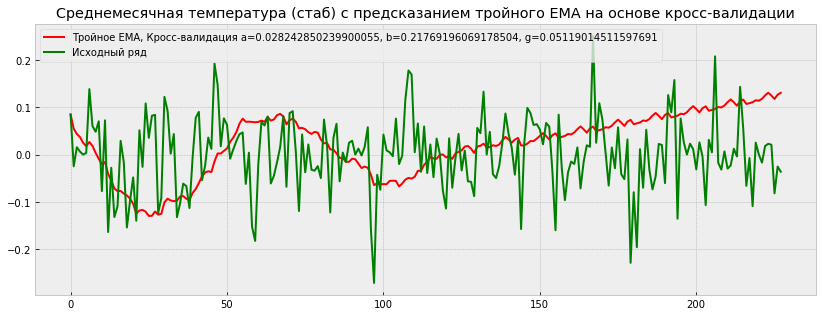

In [285]:
# Теперь сравним предсказанный ряд с исходным
monthly_temp_stab_cross_tema_pred = triple_exponential_smoothing(monthly_temp_stab[:150], 12, 
                                                            alpha_temp_stab_cross, beta_temp_stab_cross, gamma_temp_stab_cross, 
                                                            len(val_temp_stab_cross))

DataSets = [
        {'seria': monthly_temp_stab_cross_tema_pred, 'color': 'red', 
             'label': f'Тройное EMA, Кросс-валидация a={alpha_temp_stab_cross}, b={beta_temp_stab_cross}, g={gamma_temp_stab_cross}'},
        {'seria': monthly_temp_stab, 'color': 'green', 
             'label': 'Исходный ряд'}
    ]

plot_dts(DataSets, 'Среднемесячная температура (стаб) с предсказанием тройного EMA на основе кросс-валидации')

Неожиданный для меня результат. В некотором роде можно сказать, что мы в результате до 150-го значения получили кривую, которая действительно подтверждает наличие циклов солнечной активности. Ну а предсказания после 150-го значения медленно растут с видимой сезонностью в 12 месяцев,поскольку, видимо, с 100 по 150 значение в результате очередного цикла солнечной активности наблюдался стабильный рост среднемесячной температуры.

sic!